# School Re-opening

- Simulation Start Date: September 15, 2021 
- Validation Data: September 16, 2021 - December 25, 2021 (100 days)
- Steps: 100
- Iterations: 20 

## 1. SEIRDV Data and Parameter Values

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

### 1.1 Population

2015 Population
- Source: https://psa.gov.ph/content/philippine-population-surpassed-100-million-mark-results-2015-census-population
- Accessed: January 15, 2021

In [2]:
region_pop_2015 = [
    96663 + 405449, # 0 - 4
    510858, # 5 - 9
    502318, # 10 - 14
    474530, # 15 - 19
    474530, # 20 - 24
    391660, # 25 - 29
    365782, # 30 - 34
    336500,  # 35 - 39
    295564,  # 40 - 44
    276698,  # 45 - 49
    237159,  # 50 - 54
    201337,  # 55 - 59
    159163,  # 60 - 64
    123030,  # 65 - 69
    82362,  # 70 - 74
    61471,   # 75 - 79
    67169,   # 80 years and over
]

# Population Distribution in 2015
region_pop_2015_dist = np.divide(region_pop_2015, sum(region_pop_2015))

We use the population distribution of region in 2015 to estimate the distribution in 2020. 

2020 Population 
- Source: https://psa.gov.ph/content/2020-census-population-and-housing-2020-cph-population-counts-declared-official-president
- Accessed: December 11, 2021

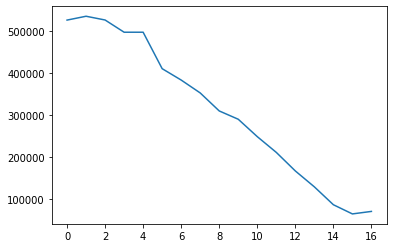

In [3]:
region_pop_2020 = 5301139
region_pop_2020 = region_pop_2020 * region_pop_2015_dist
plt.plot(region_pop_2020)

### 1.2 DOH Data: Active, Dead, Recovered 

The COVID-19 data from the DOH Data Drop is divided into three batches, i.e., 0, 1, and 2. We will combine the number of active, dead, and recovered individuals from 2020 to August 1, 2021.

In [4]:
import utils.covid_data_extractor as covid_extractor

region = "Region I: Ilocos Region"
batches = 3
age_groups = 17
active = np.zeros(age_groups)
deaths = np.zeros(age_groups)
recoveries = np.zeros(age_groups)

for i in range(batches):
    # Opens the file and instantiates the extractor
    filename = "input/covid_data/DOH COVID Data Drop_ 20211209 - 04 Case Information_batch_%i.csv" % (i)
    extractor = covid_extractor.DOHCovid19DataExtractor(filename)
    
    # Sets start and end dates to filter records that are gathered within the dates (inclusive)
    start = {"m": 1, "d": 1, "y": 2020}
    end = {"m": 9, "d": 15, "y": 2021}
    extractor.cut_data(start, end, 'DateResultRelease')
    
    # Extracts the cases in the region
    cases = extractor.count_cases("RegionRes", region)
    active = active + cases["I"]
    deaths = deaths + cases["D"]
    recoveries = recoveries + cases["R"]
    
pd.DataFrame([active, deaths, recoveries], index=["active", "dead", "recovered"]).transpose()

<ipython-input-4-290af7fd5752>:13: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  extractor = covid_extractor.DOHCovid19DataExtractor(filename)


,active,dead,recovered
0,3.0,9.0,1827.0
1,0.0,3.0,1821.0
2,2.0,2.0,2581.0
3,2.0,10.0,3285.0
4,11.0,11.0,5494.0
5,18.0,19.0,6520.0
6,15.0,32.0,5705.0
7,19.0,41.0,4805.0
8,21.0,58.0,4311.0
9,10.0,73.0,3732.0


### 1.3 Vaccinated as of August 2, 2021

We estimate the number of vaccinated individuals in region as of August 2, 2021 (v_region_then).
- 1) We get the latest region - PH vaccination ratio (v_ratio_now = v_region_now / v_ph_now). 
- 2) We estimate the number of vaccinated individuals in region as of Aug 2, 2021 (v_region_then = v_ratio_then * v_ph_then)

Data Sources:

v_region_now
- Fully Vaccinated in region as of December 25, 2021. 
- Source: https://news.abs-cbn.com/spotlight/multimedia/infographic/03/23/21/philippines-covid-19-vaccine-tracker. 
- Accessed: January 15, 2021

v_ph_now
- Fully Vaccinated in PH as of December 25, 2021
- Source: https://news.abs-cbn.com/spotlight/multimedia/infographic/03/23/21/philippines-covid-19-vaccine-tracker
- Accessed: January 15, 2021

v_ph_then
- Fully vaccinated in PH as of August 2, 2021
- Source: https://ourworldindata.org/covid-vaccinations?country=PHL
- Accessed: December 2, 2021

In [5]:
# Step 1
v_ph_now = 39560598
v_region_now = 1805605
v_ratio_now = v_region_now / v_ph_now

# Step 2
v_ph_then = 9115163
v_region_then = v_ratio_now * v_ph_then

v_region_ratio = v_region_then / sum(region_pop_2020) 
vaccinated = v_region_then
v_region_ratio, vaccinated

(0.07847930497932656, 416029.7043188023)

### 1.4 Vaccine Efficacy Estimate

We estimate the average efficacy by getting the weighted average of efficacy (lower bound) of the vaccines and the supply available in the Philippines.

Data:
- Supply in PH as of Oct 10, 2021

In [6]:
sinovac = 41500000
astrazeneca = 11103340
pfizer = 23328630
sputnik_v = 1290000
johnson_and_johnson = 3240850
moderna = 9985800
sinopharm = 1100000
supply = [sinovac, astrazeneca, pfizer, sputnik_v, johnson_and_johnson, moderna, sinopharm]
efficacy = [0.650, 0.704, 0.950, 0.916, 0.669, 0.941, 0.790] # lower bound

# Weighted Average
expected_efficacy = sum(np.multiply(supply, efficacy)) / sum(supply) 
expected_efficacy = 0.770840197

### 1.6 SEIRDV

- n = region's 2020 Population
- e = exposed = 0 (assumption) 
- i = infectious = active 
- r = recovered
- d = dead 
- v = vaccinated
- s = n - (e + i + r + d + v)

In [7]:
n = region_pop_2020
e = 0 # assumption 
i = active 
r = recoveries 
d = deaths
s = n - (e + i + r + d)

Vaccination Scenarios: 0%, 25%, 50%, 75%, 100%

In [8]:
# Eligible population: Ages 16 and above only 
eligible = np.concatenate(([0, 0, 0], s[3:]))

# Vaccinated Individuals
v_control = eligible * expected_efficacy * v_region_ratio * 0
v_25 = eligible * expected_efficacy * 0.25
v_50 = eligible * expected_efficacy * 0.5
v_75 = eligible * expected_efficacy * 0.75
v_100 =  eligible * expected_efficacy * 1
v_scenarios = [v_control, v_25, v_50, v_75, v_100]

# SEIRDV Data for each scenario
seirdv_control = {}
seirdv_25 = {}
seirdv_50 = {}
seirdv_75 = {}
seirdv_100 = {}
seirdv_data = [seirdv_control, seirdv_25, seirdv_50, seirdv_75, seirdv_100]

for j, seirdv in enumerate(seirdv_data):
    seirdv["S"] = s - v_scenarios[j]
    seirdv["E"] = e
    seirdv["I"] = i
    seirdv["R"] = r
    seirdv["D"] = d
    seirdv["V"] = v_scenarios[j]

print("Control Scenario")
pd.DataFrame(seirdv_control)

Control Scenario


,S,E,I,R,D,V
0,523968.533453,0,3.0,1827.0,9.0,0.0
1,533142.272315,0,0.0,1821.0,3.0,0.0
2,523438.254949,0,2.0,2581.0,2.0,0.0
3,493626.891182,0,2.0,3285.0,10.0,0.0
4,491407.891182,0,11.0,5494.0,11.0,0.0
5,403586.112597,0,18.0,6520.0,19.0,0.0
6,377291.885032,0,15.0,5705.0,32.0,0.0
7,347515.016823,0,19.0,4805.0,41.0,0.0
8,305122.176203,0,21.0,4311.0,58.0,0.0
9,285940.857042,0,10.0,3732.0,73.0,0.0


### 1.7 Rescaled SEIRDV

We rescale each of our SEIRDV data to reduce the memory requirement of our simulations. Our target population is 25000 agents. The real agent population will vary because of rounding offsets. 

In [9]:
target_agent_pop = sum(region_pop_2020 // 257)
target_agent_pop

20618.0

In [10]:
for i, seirdv in enumerate(seirdv_data):
    seirdv_data[i] = pd.DataFrame(seirdv_data[i]) / sum(n) # Distribution
    seirdv_data[i] = seirdv_data[i] * target_agent_pop # Rescale
    seirdv_data[i] = seirdv_data[i].apply(np.ceil) # Ceiling of values
    seirdv_data[i] = dict([(state, [int(i) for i in list(seirdv_data[i][state].values)]) for state in "SEIRDV"])

seirdv_control, seirdv_25, seirdv_50, seirdv_75, seirdv_100 = seirdv_data
print("Control Scenario")
pd.DataFrame(seirdv_control)

Control Scenario


,S,E,I,R,D,V
0,2038,0,1,8,1,0
1,2074,0,0,8,1,0
2,2036,0,1,11,1,0
3,1920,0,1,13,1,0
4,1912,0,1,22,1,0
5,1570,0,1,26,1,0
6,1468,0,1,23,1,0
7,1352,0,1,19,1,0
8,1187,0,1,17,1,0
9,1113,0,1,15,1,0


### 1.8 Parameter Values

- infection rate
- death rate
- recovery rate

In [11]:
# data from NCR notebook

infection_rate = [0.022898,0.026656,0.034381,0.047721,0.108896,0.144863,0.122790,0.094087,0.080113,0.066014,0.063241,0.055364,0.044781,0.033374,0.024340,0.013441,0.017038]
death_rate = [0.000112,0.000020,0.000042,0.000074,0.000141,0.000284,0.000344,0.000484,0.000697,0.000839,0.001337,0.001665,0.002147,0.002304,0.002259,0.001574,0.002447]
recovery_rate = [0.022781,0.026632,0.034336,0.047645,0.108761,0.144590,0.122454,0.093608,0.079418,0.065177,0.061905,0.053699,0.042633,0.031067,0.022076,0.011862,0.014586]

pd.DataFrame([infection_rate, death_rate, recovery_rate], index=["infection_rate", "death_rate", "recovery_rate"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
infection_rate,0.022898,0.026656,0.034381,0.047721,0.108896,0.144863,0.122790,0.094087,0.080113,0.066014,0.063241,0.055364,0.044781,0.033374,0.024340,0.013441,0.017038
death_rate,0.000112,0.000020,0.000042,0.000074,0.000141,0.000284,0.000344,0.000484,0.000697,0.000839,0.001337,0.001665,0.002147,0.002304,0.002259,0.001574,0.002447
recovery_rate,0.022781,0.026632,0.034336,0.047645,0.108761,0.144590,0.122454,0.093608,0.079418,0.065177,0.061905,0.053699,0.042633,0.031067,0.022076,0.011862,0.014586


## 2. Contact Matrices 

In [12]:
import utils.utils

### 2.1 No School Re-opening

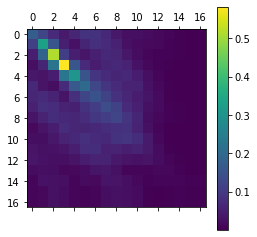

In [13]:
cm0 = utils.utils.parse_json("input/contact_matrices/cm_0.json") # No opening
plt.matshow(cm0)
plt.colorbar()

### 2.2 100% School Re-opening

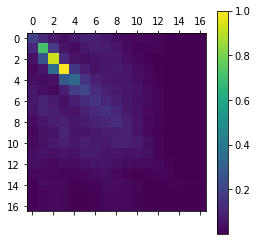

In [14]:
cm100 = utils.utils.parse_json("input/contact_matrices/cm_100.json")
plt.matshow(cm100)
plt.colorbar()

## 3. Simulations

In [15]:
from batchrunner import batchrun

iterations = 20
steps = 300

### 3.1 Vaccination Scenarios under No School Reopening Scenario

In [16]:
fixed_params = utils.utils.parse_json("input/fixed_params.json")
fixed_params["infection_rate"] = infection_rate
fixed_params["death_rate"] = death_rate
fixed_params["recovery_rate"] = recovery_rate

scenarios = {
    "sim0": seirdv_control, 
    "sim1": seirdv_25, 
    "sim2": seirdv_50, 
    "sim3": seirdv_75, 
    "sim4": seirdv_100
}

for sim_id in scenarios:
    print(sim_id)
    batchrun(iterations, steps, sim_id, scenarios[sim_id], fixed_params, cm0, "output/ILOCOS/output_0")

sim0
running...
Batch run finished.
sim1
running...
Batch run finished.
sim2
running...
Batch run finished.
sim3
running...
Batch run finished.
sim4
running...
Batch run finished.


### 3.2 Vaccination Scenarios under 100% School Reopening Scenario

In [17]:
for sim_id in scenarios:
        print(sim_id)
        batchrun(iterations, steps, sim_id, scenarios[sim_id], fixed_params, cm100, "output/ILOCOS/output_100")

sim0
running...
Batch run finished.
sim1
running...
Batch run finished.
sim2
running...


## 4. Analysis

In [ ]:
import utils.analysis

total_population = sum(pd.DataFrame(pd.DataFrame(i).sum() for i in seirdv_data).sum()) / len(seirdv_data)
scale = 10000
sim_ids = {
    "sim0": "0% Vaccination",
    "sim1": "25% Vaccination",
    "sim2": "50% Vaccination",
    "sim3": "75% Vaccination",
    "sim4": "100% Vaccination"
}
colors = {
    "sim0": "k", 
    "sim1": "C1", 
    "sim2": "C2", 
    "sim3": "C3", 
    "sim4": "C4"
}
styles = {
    "sim0": ":", 
    "sim1": "-", 
    "sim2": "-", 
    "sim3": "-", 
    "sim4": "-"
}
states = "SEIRDV"

### 4.1 No School Re-opening

#### 4.1.1 Age Dynamics

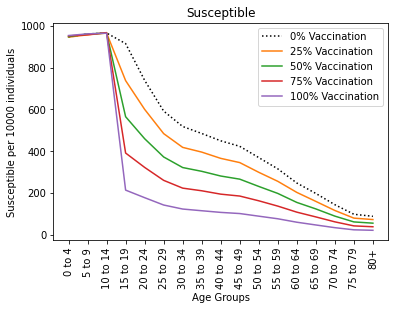

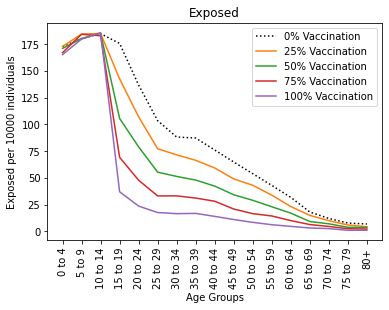

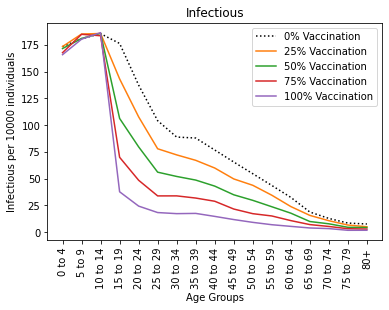

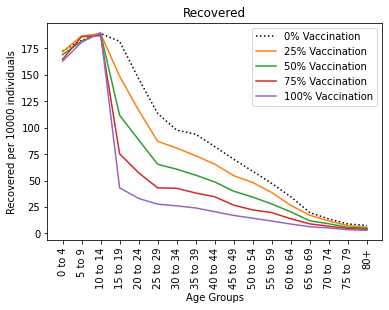

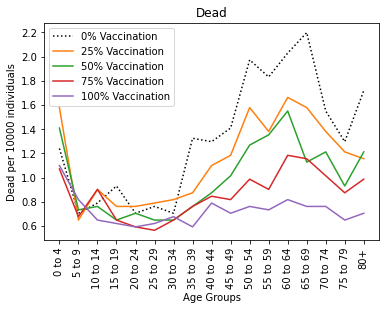

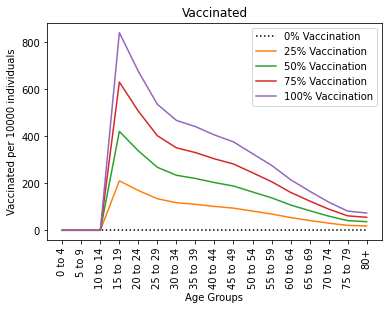

In [ ]:
utils.analysis.plot_average_age_dist(
    sim_ids, 
    states, 
    iterations, 
    total_population, 
    scale, colors, 
    styles, 
    "output/ILOCOS/output_0"
)

#### 4.1.2 Temporal Dynamics

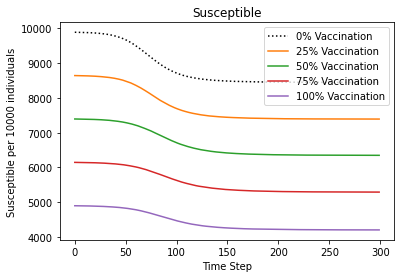

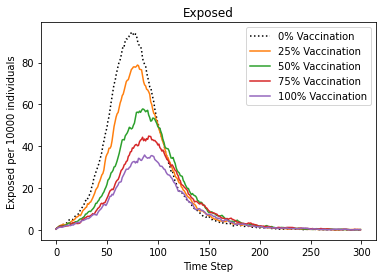

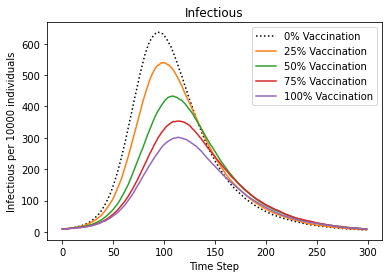

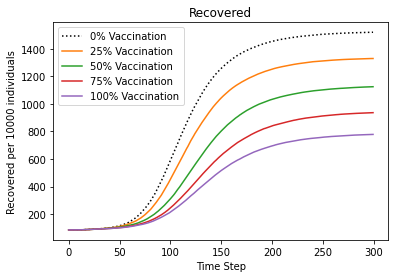

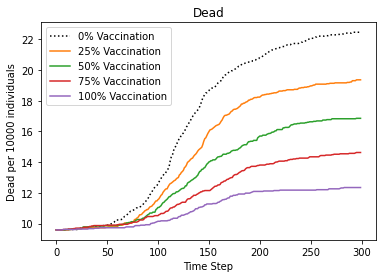

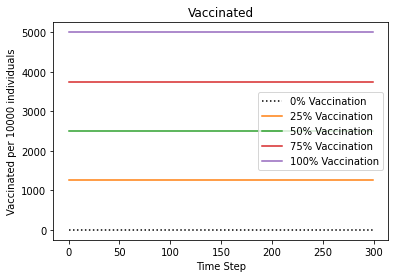

In [ ]:
utils.analysis.plot_average_time_series(
    sim_ids, 
    states, 
    steps, 
    iterations, 
    total_population, 
    scale, 
    colors, 
    styles, 
    "output/ILOCOS/output_0"
)

### 4.2 100% School Re-opening

#### 4.2.1 Age Dynamics

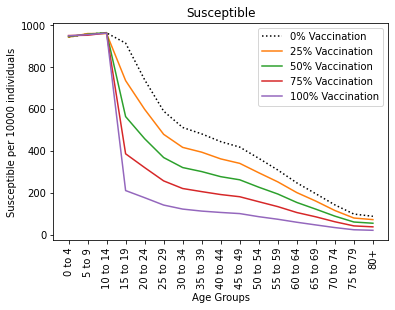

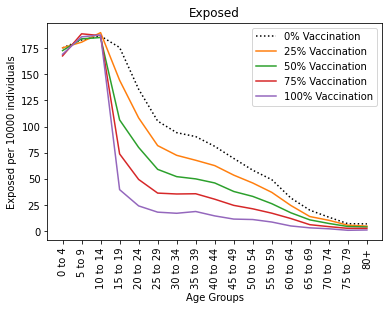

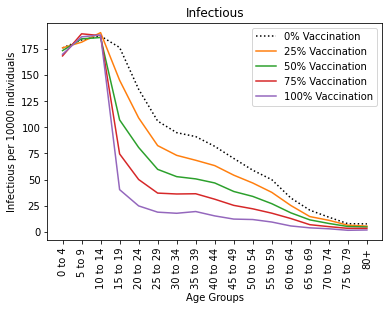

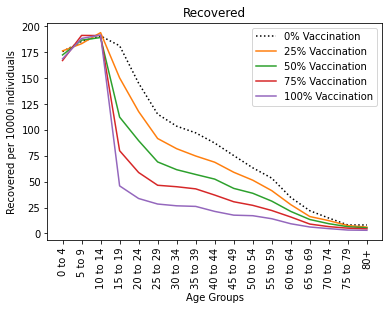

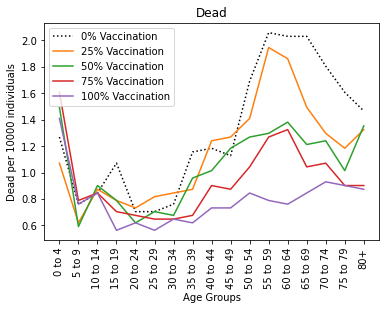

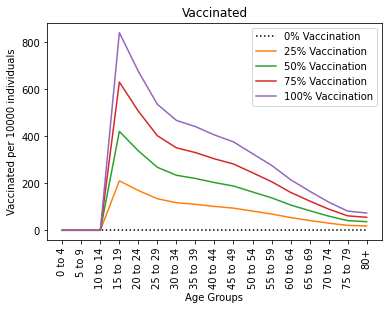

In [ ]:
utils.analysis.plot_average_age_dist(
    sim_ids, 
    states, 
    iterations, 
    total_population, 
    scale, colors, 
    styles, 
    "output/ILOCOS/output_100"
)

#### 4.2.2 Temporal Dynamics

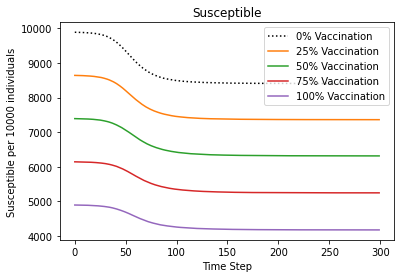

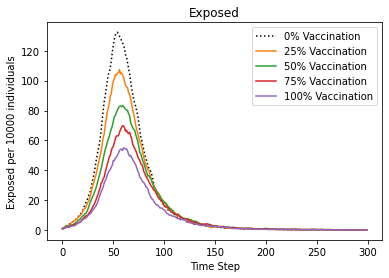

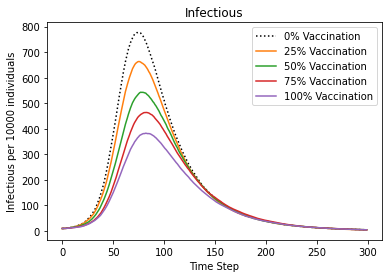

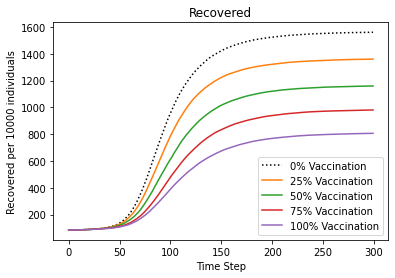

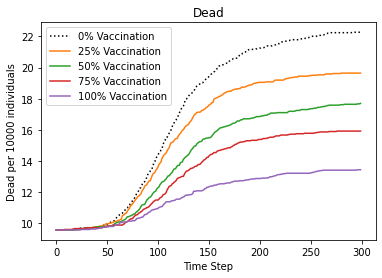

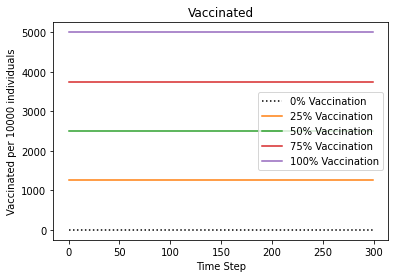

In [ ]:
utils.analysis.plot_average_time_series(
    sim_ids, 
    states, 
    steps, 
    iterations, 
    total_population, 
    scale, 
    colors, 
    styles, 
    "output/ILOCOS/output_100"
)

### 4.3 Summary

In [ ]:
summary_0 = pd.DataFrame([])
summary_100 = pd.DataFrame([])

for sim_id in sim_ids:
    summary_0[sim_id] = pd.DataFrame(
        utils.analysis.get_average_age_dist(
            sim_id, 
            iterations, 
            states, 
            "output/ILOCOS/output_0"), 
        index=['S', "E", "I", "R", "D", "V"]).sum(axis=1)
    summary_100[sim_id] = pd.DataFrame(
        utils.analysis.get_average_age_dist(
            sim_id, 
            iterations, 
            states, 
            "output/ILOCOS/output_100"), 
        index=['S', "E", "I", "R", "D", "V"]).sum(axis=1)
    
summary_0 = summary_0
summary_100 = summary_100

#### 4.3.1 Summary

In [ ]:
summary_0

,sim0,sim1,sim2,sim3,sim4
S,14984.65,13114.30,11263.05,9386.20,7455.50
E,2562.35,2220.70,1855.95,1517.80,1234.50
I,2579.20,2237.30,1872.60,1534.65,1251.25
R,2695.85,2357.70,1994.55,1660.45,1380.55
D,39.85,34.35,29.90,25.95,21.90
V,0.00,2224.00,4438.00,6651.00,8869.00


In [ ]:
summary_100

,sim0,sim1,sim2,sim3,sim4
S,14914.35,13063.80,11206.30,9312.50,7412.55
E,2632.65,2271.20,1912.70,1591.50,1277.45
I,2649.60,2288.00,1929.55,1608.40,1294.40
R,2770.15,2414.10,2058.15,1740.25,1430.75
D,39.50,34.85,31.40,28.25,23.85
V,0.00,2224.00,4438.00,6651.00,8869.00


In [ ]:
control_scenario = summary_0 * 0 
control_scenario["sim0"] = summary_0["sim0"]
control_scenario

,sim0,sim1,sim2,sim3,sim4
S,14984.65,0.0,0.0,0.0,0.0
E,2562.35,0.0,0.0,0.0,0.0
I,2579.20,0.0,0.0,0.0,0.0
R,2695.85,0.0,0.0,0.0,0.0
D,39.85,0.0,0.0,0.0,0.0
V,0.00,0.0,0.0,0.0,0.0


#### 4.3.2 Change in Infections and Deaths

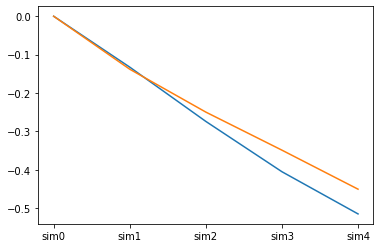

In [ ]:
change_0 = ((summary_0.transpose() - summary_0["sim0"]) / summary_0["sim0"]).transpose()
infection_change_0 = change_0.transpose()["I"]
death_change_0 = change_0.transpose()["D"]

plt.plot(infection_change_0)
plt.plot(death_change_0)

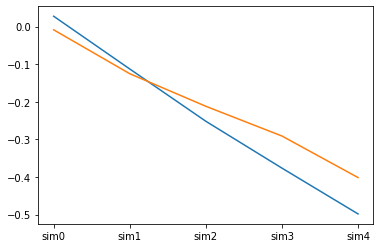

In [ ]:
change_100 = ((summary_100.transpose() - summary_0["sim0"]) / summary_0["sim0"]).transpose()
infection_change_100 = change_100.transpose()["I"]
death_change_100 = change_100.transpose()["D"]

plt.plot(infection_change_100)
plt.plot(death_change_100)

In [ ]:
infection_change_100

sim0    0.027295
sim1   -0.112903
sim2   -0.251880
sim3   -0.376396
sim4   -0.498139
Name: I, dtype: float64

In [ ]:
death_change_100

sim0   -0.008783
sim1   -0.125471
sim2   -0.212045
sim3   -0.291092
sim4   -0.401506
Name: D, dtype: float64

In [ ]:
v = [0, 25, 50, 75, 100]

death_downtick = 0
infection_downtick = 0

for i in range(5):
    if death_change_100[0] < 0 or death_change_100[4] > 0 :
        break
    
    if death_change_100[i] < 0:
        x = [v[i - 1], v[i]]
        y = [death_change_100[i - 1], death_change_100[i]]

        coefficients = np.polyfit(x, y, 1)
        
        death_downtick = abs(coefficients[1] / coefficients[0])
        break

for i in range(5):
    if infection_change_100[0] < 0 or infection_change_100[4] > 0:
        break
    
    if infection_change_100[i] < 0:
        x = [v[i - 1], v[i]]
        y = [infection_change_100[i - 1], infection_change_100[i]]

        coefficients = np.polyfit(x, y, 1)

        infection_downtick = abs(coefficients[1] / coefficients[0])
        break

output = "Death Downtick: {d}%\n Infection Downtick: {i}%".format(d = death_downtick, i = infection_downtick)
output

'Death Downtick: 0%\n Infection Downtick: 4.867256637168105%'

#### 4.3.3 Combined Graphs

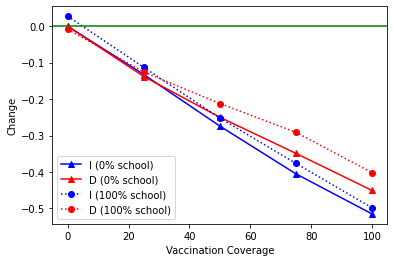

In [ ]:
plt.xlabel("Vaccination Coverage")
plt.ylabel("Change")
plt.plot(v, infection_change_0, "b-^")
plt.plot(v, death_change_0, "r-^")
plt.plot(v, infection_change_100, "b:o")
plt.plot(v, death_change_100, "r:o")
plt.axhline(y=0, color='g', linestyle='-')
plt.legend(["I (0% school)", "D (0% school)", "I (100% school)", "D (100% school)"])

#### 4.3.4 Interpolation

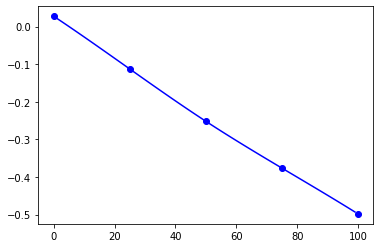

In [ ]:
from scipy import interpolate
tck_infection = interpolate.CubicSpline(v, infection_change_100)
xnew = np.arange(0, 100, 1)
plt.plot(v, infection_change_100, 'ob', xnew, tck_infection(xnew),'b')

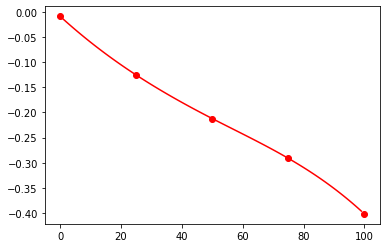

In [ ]:
tck_death = interpolate.CubicSpline(v, death_change_100)
xnew = np.arange(0, 100, 1)
plt.plot(v, death_change_100, 'or', xnew, tck_death(xnew),'r')

Text(0.5, 1.0, 'Vaccination Scenarios Under 100% School Re-opening')

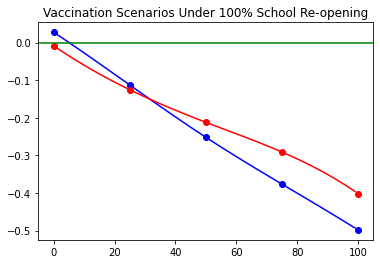

In [ ]:
plt.plot(v, infection_change_100, 'ob', xnew, tck_infection(xnew),'b')
plt.plot(v, death_change_100, 'or', xnew, tck_death(xnew),'r')
plt.axhline(y=0, color='g', linestyle='-')
plt.title("Vaccination Scenarios Under 100% School Re-opening")